
# 有限元算例-Helmholtz 方程求解

本节将引导您使用 FEALPy 完成 Helmholtz 方程的有限元求解，现定义如下数学模型：

$$
\begin{cases}
-\Delta u - k^2 u = f & \text{在 } \Omega = [-0.5,0.5]^2 \\
\frac{\partial u}{\partial n} + iku = g & \text{在 } \partial \Omega
\end{cases}
$$

其中我们定义真解为：

$$
u(x, y) = \frac{cos(k·r) - c·J_0(k·r)}{k} \\
\text{其中 }~
c = \frac{(cos(k) + i·sin(k))}{J_0(k) + i·J_1(k)}, ~r = \sqrt{x^2 + y^2},~J_0(k)~ 和~J_1(k)~是 ~Bessel ~函数, ~i~是虚数单位，~k~是波数。
$$



源项为：

$$
f(x,y) = \frac{sin(k·r)}{r}
$$

变分形式为：

$$
(\nabla u_h, \nabla v_h) - k^2(u_h, v_h) + ik<u_h,v_h>_{\partial \Omega} = (f, v_h) + <g,v_h>_{\partial \Omega}, \quad \forall v_h \in H^1
$$


### 1. 定义 PDE 模型

In [1]:
from fealpy.backend import backend_manager as bm
from fealpy.decorator import cartesian
from scipy.special import jv

# 方程的常数项
k = bm.tensor(1.0)
c = (bm.cos(k) + bm.sin(k) * 1j) / (jv(0, k) - jv(1, k) * 1j)


# 定义域
def domain():
    return [-0.5, 0.5, -0.5, 0.5]

# 真解
@cartesian
def solution(p):
    x = p[..., 0]
    y = p[..., 1]
    r = bm.sqrt(x**2 + y**2)
    val = (bm.cos(k * r) - c * jv(0, k * r)) / k
    return val

# 源项
@cartesian
def source(p):
    x = p[..., 0]
    y = p[..., 1]
    r = bm.sqrt(x**2 + y**2)
    val = bm.sin(k * r) / r
    return val

# 梯度
@cartesian
def gradient(p):
    x, y = p[..., 0], p[..., 1]
    r = bm.sqrt(x**2 + y**2)
    u_r = c * jv(1, k * r) - bm.sin(k * r)
    du_dx = u_r * x / r
    du_dy = u_r * y / r
    val = bm.stack((du_dx, du_dy), axis=-1)
    return val

# dirichlet 边界条件
@cartesian
def robin(p, n):
    kappa = 1j * k
    grad = gradient(p)
    val = bm.sum(grad * n[:, None, :], axis=-1)
    val += kappa * solution(p)
    return val

### 2. 进行参数配置和初始化

设置后端

In [2]:
from fealpy.backend import backend_manager as bm

backend = 'numpy'
device = 'cpu'
bm.set_backend(backend)

导入日志工具

In [3]:
from fealpy.utils import timer
from fealpy import logger

logger.setLevel('WARNING')
tmr = timer()
next(tmr)

设置初始网格和加密次数

In [4]:
from fealpy.mesh import TriangleMesh

mesh = TriangleMesh.from_box(domain(), nx=4, ny=4)
maxit = 4

定义误差存储矩阵

In [5]:
errorMatrix = bm.zeros((1, maxit), dtype=bm.float64)

### 3. 有限元求解

流程包含：

(1)构建 Lagrange 有限元空间

(2)组装刚度矩阵 $A$ 和载荷向量 $F$

(3)处理 Robin 边界条件

(4)求解线性系统 $A u_h = F$

(5)计算L2误差 $\|u - u_h\|_{L^2(\Omega)}$

(6)网格均匀加密

In [6]:
from fealpy.functionspace import LagrangeFESpace
from fealpy.fem import BilinearForm, ScalarSourceIntegrator, ScalarRobinSourceIntegrator
from fealpy.fem import LinearForm, ScalarDiffusionIntegrator, ScalarRobinBCIntegrator, ScalarMassIntegrator
from fealpy.solver import cg

for i in range(maxit):
    space = LagrangeFESpace(mesh, p=1)
    tmr.send(f'第{i}次空间时间')
    uh = space.function(dtype=bm.complex128)

    D = ScalarDiffusionIntegrator(q=3)
    M = ScalarMassIntegrator(coef=-k**2,q=3)
    R = ScalarRobinBCIntegrator(coef=1j * k, q=3)
    bform = BilinearForm(space)
    bform.add_integrator(D)
    bform.add_integrator(M)
    bform.add_integrator(R)
    A = bform.assembly()

    lform = LinearForm(space)
    lform.add_integrator(ScalarSourceIntegrator(source, q=3))
    lform.add_integrator(ScalarRobinSourceIntegrator(robin, q=3))
    F = lform.assembly()

    tmr.send(f'第{i}次矩阵组装时间')
    
    gdof = space.number_of_global_dofs()
    uh[:] = cg(A, F)
    tmr.send(f'第{i}次求解器时间')
    gdof = space.number_of_global_dofs()
    errorMatrix[0, i] = mesh.error(solution, uh.value)
    if i < maxit-1:
        mesh.uniform_refine(n=1)
    tmr.send(f'第{i}次误差计算及网格加密时间')

### 4. 误差分析和收敛阶计算

In [7]:
next(tmr)
print("最终误差 :",errorMatrix)
print("order : ", bm.log2(errorMatrix[0,:-1]/errorMatrix[0,1:]))

Timer received None and paused.
   ID       Time        Proportion(%)    Label
-------------------------------------------------
    1    264.281 [ms]          87.381    第0次空间时间
    2      4.107 [ms]           1.358    第0次矩阵组装时间
    3    262.976 [us]           0.087    第0次求解器时间
    4    660.658 [us]           0.218    第0次误差计算及网格加密时间
    5     34.332 [us]           0.011    第1次空间时间
    6      2.799 [ms]           0.925    第1次矩阵组装时间
    7    458.956 [us]           0.152    第1次求解器时间
    8    727.892 [us]           0.241    第1次误差计算及网格加密时间
    9     28.849 [us]           0.010    第2次空间时间
   10      4.672 [ms]           1.545    第2次矩阵组装时间
   11      1.016 [ms]           0.336    第2次求解器时间
   12      1.616 [ms]           0.534    第2次误差计算及网格加密时间
   13     28.133 [us]           0.009    第3次空间时间
   14     15.250 [ms]           5.042    第3次矩阵组装时间
   15      3.284 [ms]           1.086    第3次求解器时间
   16      3.222 [ms]           1.065    第3次误差计算及网格加密时间
最终误差 : [[0.00765197 0.00199163 0.00050404 0.000

### 5. 结果可视化
在单元重心处计算真解和数值解，并进行可视化比较

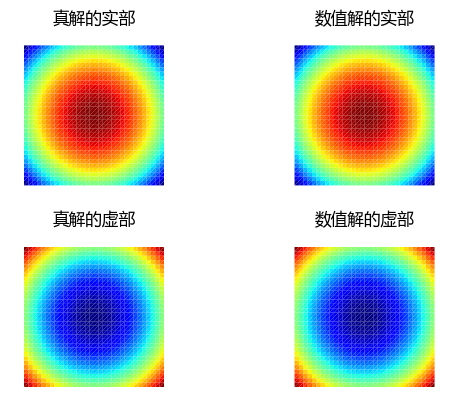

In [ ]:
from matplotlib import pyplot as plt

bc = bm.array([[1/3, 1/3, 1/3]], dtype=bm.float64)
ps = mesh.bc_to_point(bc)
u = bm.to_numpy(solution(ps))
uh0 = bm.to_numpy(uh(bc))

fig, axes = plt.subplots(2, 2)
mesh.add_plot(axes[0, 0], cellcolor=u.real, linewidths=0)
axes[0, 0].set_title('真解的实部', fontname='Microsoft YaHei')
mesh.add_plot(axes[0, 1], cellcolor=uh0.real, linewidths=0)
axes[0, 1].set_title('数值解的实部', fontname='Microsoft YaHei')
mesh.add_plot(axes[1, 0], cellcolor=u.imag, linewidths=0)
axes[1, 0].set_title('真解的虚部', fontname='Microsoft YaHei')
mesh.add_plot(axes[1, 1], cellcolor=uh0.imag, linewidths=0)
axes[1, 1].set_title('数值解的虚部', fontname='Microsoft YaHei')
plt.show()